In [29]:
# Code based of https://dylancope.github.io/Multiagent-RL-with-TFAgents/
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from functools import partial
from IPython.display import clear_output
from itertools import cycle
from pathlib import Path
import random
from time import time
from typing import Tuple, List, Callable, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tf_agents.typing import types
%matplotlib inline
import seaborn as sns
sns.set()
import tensorflow as tf
from tf_agents.agents import DqnAgent
from tf_agents.agents.tf_agent import LossInfo
from tf_agents.environments.py_environment import PyEnvironment
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.networks.q_rnn_network import QRnnNetwork
from tf_agents.networks.q_network import QNetwork
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.specs import TensorSpec
from tf_agents.trajectories import trajectory
from tf_agents.trajectories.time_step import TimeStep
from tf_agents.trajectories.trajectory import Trajectory
from tf_agents.utils import common

print('Physical Devices:\n', tf.config.list_physical_devices(), '\n\n')

OUTPUTS_DIR = f'./outputs/{int(10000000 * time())}'
print('Output Directory:', OUTPUTS_DIR)

Physical Devices:
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')] 


Output Directory: ./outputs/16218463390460790


In [30]:
LOST = 0.95
DISCOUNT = np.float32(1.0)
import abc
from tf_agents.environments import py_environment
from tf_agents.specs import BoundedArraySpec
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories.time_step import StepType
tf.compat.v1.enable_v2_behavior()

class EnglishAuction(py_environment.PyEnvironment):


    def __init__(self):
        bid_spec = BoundedArraySpec(
            (), dtype=np.int32, minimum=0, maximum=2
        )
        player_spec = BoundedArraySpec(shape=(1,),dtype=np.int32, minimum=1, maximum=1)
        self._action_spec = {
            "bid": bid_spec,
            "player": player_spec
        }
        minimum = np.zeros((1,5), dtype=np.int32)
        maximum = np.array([[100,2,2,100,100]], dtype=np.int32)
        self._observation_spec = BoundedArraySpec(
            shape=(1,5), dtype=np.int32, name="observation", maximum=maximum, minimum=minimum
        )
        self._state = np.zeros(shape=(1,7), dtype=np.int32)
        self._state[0,1:3] = 2
        valuations = np.zeros((1,4))
        for x in range(2):
            valu = np.random.rand(1,2)
            valuations[0,2*x] = np.amax(valu) * 100
            valuations[0,1+2*x] = np.amin(valu) * 100

        self._state[:,3:7] = valuations
        self._done = False
        self._current_time_step = TimeStep(step_type=StepType.FIRST, reward=0, discount=DISCOUNT, observation=self._state)

    def _reset(self):
        self._state = np.zeros(shape=(1,7), dtype=np.int32)
        self._state[0,1:3] = 2
        valuations = np.zeros((1,4))
        for x in range(2):
            valu = np.random.rand(1,2)
            valuations[0,2*x] = np.amax(valu) * 100
            valuations[0,1+2*x] = np.amin(valu) * 100

        self._state[:,3:7] = valuations
        self._done = False
        return ts.restart(np.array(self._state, dtype=np.int32))

    def __calculateWinnings(self, player):
        player_payment = self._state[0, 0] * self._state[0,player]
        player_revenue = 0
        if self._state[0,player] >= 1:
            player_revenue += self._state[0, 3 + (player-1)*2]
        if self._state[0,player] == 2:
            player_revenue += self._state[0, 4 + (player-1)*2]
        return np.float32(player_revenue - player_payment)

    def _step(self, action):

        if self._done:
            return self._reset()

        player = action["player"]
        bid = action["bid"]
        if self._state[0, 1] + self._state[0, 2] <= 2:
            return TimeStep(StepType.LAST,
                            self.__calculateWinnings(player),
                            DISCOUNT,
                            self._state
                            )
        self._state[0,player] = bid
        if self._state[0, 1] + self._state[0, 2] <= 2:
            return TimeStep(StepType.MID,
                            self.__calculateWinnings(player),
                            DISCOUNT,
                            self._state
                            )
        res_rev = np.float32(0)
        if self.__calculateWinnings(player) < -20:
            res_rev += self.__calculateWinnings(player)
        if res_rev < -150:
            return TimeStep(
            StepType.LAST,
            res_rev * np.float32(3),
            DISCOUNT,
            self._state)

        self._state[0,0] += 1
        res_rev *= np.float32(0.1)
        return TimeStep(
            StepType.MID,
            res_rev,
            DISCOUNT,
            self._state
        )
    def observation_spec(self) -> types.NestedArraySpec:
        return self._observation_spec

    def action_spec(self) -> types.NestedArraySpec:
        return self._action_spec

    def get_info(self) -> Any:
        pass

    def get_state(self) -> Any:
        return self._state

    def set_state(self, state: Any) -> None:
        self._state = state

In [31]:
class IMAgent(DqnAgent):

    def __init__(self,
                 env: TFPyEnvironment,
                 player_id,
                 observation_spec: TensorSpec = None,
                 action_spec: TensorSpec = None,
                 reward_fn: Callable = lambda time_step: time_step.reward,
                 action_fn: Callable = lambda action: action,
                 name: str='IMAgent',
                 q_network=None,
                 # training params
                 replay_buffer_max_length: int = 1000,
                 learning_rate: float = 1e-5,
                 training_batch_size: int = 8,
                 training_parallel_calls: int = 3,
                 training_prefetch_buffer_size: int = 3,
                 training_num_steps: int = 2,
                 **dqn_kwargs):

        self._env = env
        self._reward_fn = reward_fn
        self._name = name
        self._observation_spec = observation_spec or self._env.observation_spec()
        self._action_spec = action_spec or self._env.action_spec()
        self._action_fn = action_fn
        self.player_id = player_id

        self.q_network = q_network or self._build_q_net()

        env_ts_spec = self._env.time_step_spec()
        time_step_spec = TimeStep(
            step_type=env_ts_spec.step_type,
            reward=env_ts_spec.reward,
            discount=env_ts_spec.discount,
            observation=self.q_network.input_tensor_spec
        )

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        super().__init__(time_step_spec,
                         self._action_spec,
                         self.q_network,
                         optimizer,
                         name=name,
                         epsilon_greedy=0.05,
                         **dqn_kwargs)

        self._policy_state = self.policy.get_initial_state(
            batch_size=self._env.batch_size)
        self._rewards = []

        self._replay_buffer = TFUniformReplayBuffer(
            data_spec=self.collect_data_spec,
            batch_size=self._env.batch_size,
            max_length=replay_buffer_max_length)

        self._training_batch_size = training_batch_size
        self._training_parallel_calls = training_parallel_calls
        self._training_prefetch_buffer_size = training_prefetch_buffer_size
        self._training_num_steps = training_num_steps
        self.train = common.function(self.train)

    def _build_q_net(self):
#         q_net = QRnnNetwork(input_tensor_spec=self._observation_spec,
#                             action_spec=self._action_spec,
#                             name=f'{self._name}QRNN')

        fc_layer_params = (64, 64, 64, 32)
        q_net = QNetwork(
            self._observation_spec,
            self._action_spec,
            fc_layer_params=fc_layer_params,
            activation_fn=tf.nn.relu
        )

        q_net.create_variables()
        q_net.summary()

        return q_net

    def reset(self):
        self._policy_state = self.policy.get_initial_state(
            batch_size=self._env.batch_size
        )
        self._rewards = []

    def episode_return(self) -> float:
        return np.sum(self._rewards)

    def _observation_fn(self, observation: tf.Tensor) -> tf.Tensor:

        my_id = self.player_id
        enemy_id = 2 if my_id == 1 else 1

        price = tf.slice(observation, [0,0,0],[1,1,1])
        my_demand = tf.slice(observation, [0,0,my_id],[1,1,1])
        enemy_demand = tf.slice(observation, [0,0,enemy_id],[1,1, 1])

        correct_column_index = 3 + 2 * (my_id- 1)
        my_values = observation[:,:,correct_column_index:correct_column_index+2]
        res = tf.concat([price, my_demand, enemy_demand, my_values],2)
        return res

    def _augment_time_step(self, time_step: TimeStep) -> TimeStep:

        reward = self._reward_fn(time_step)
        reward = tf.convert_to_tensor(reward, dtype=tf.float32)
        if reward.shape != time_step.reward.shape:
            reward = tf.reshape(reward, time_step.reward.shape)

        observation = self._observation_fn(time_step.observation)

        return TimeStep(
            step_type=time_step.step_type,
            reward=reward,
            discount=time_step.discount,
            observation=observation
        )

    def _current_time_step(self) -> TimeStep:
        time_step = self._env.current_time_step()
        time_step = self._augment_time_step(time_step)
        return time_step

    def _step_environment(self, action) -> TimeStep:
        action = self._action_fn(action)
        time_step = self._env.step(action)
        time_step = self._augment_time_step(time_step)
        return time_step

    def act(self, collect=False) -> Trajectory:
        time_step = self._current_time_step()

        if collect:
            policy_step = self.collect_policy.action(
                time_step, policy_state=self._policy_state)
        else:
            policy_step = self.policy.action(
                time_step, policy_state=self._policy_state)

        self._policy_state = policy_step.state
        next_time_step = self._step_environment(policy_step.action)
        traj = trajectory.from_transition(time_step, policy_step, next_time_step)

        self._rewards.append(next_time_step.reward)

        if collect:
            self._replay_buffer.add_batch(traj)

        return traj

    def train_iteration(self) -> LossInfo:
        experience, info = self._replay_buffer.get_next(
            sample_batch_size=self._training_batch_size,
            num_steps=self._training_num_steps
        )
        return self.train(experience)

    def getQNetwork(self):
        return self.q_network

In [32]:
def true_reward(observation, player_id):
    true_reward_obs = observation.numpy()
    true_reward_payment = true_reward_obs[0,0, 0] * true_reward_obs[0,0,player_id]
    true_reward_revenue = 0
    if true_reward_obs[0,0,player_id] >= 1:
        true_reward_revenue += true_reward_obs[0,0, 3 + (player_id-1)*2]
    if true_reward_obs[0,0,player_id] == 2:
        true_reward_revenue += true_reward_obs[0,0, 4 + (player_id-1)*2]

    return true_reward_revenue - true_reward_payment

In [41]:
def test(env, player_nr_1, player_nr_2):
    time_step = env.reset()
    player_nr_1.reset()
    player_nr_2.reset()
    players = cycle([player_nr_1, player_nr_2])
    counter = 0
    while counter < 150:
        counter +=1
        player = next(players)
        player.act(collect=False)
        if env.current_time_step().is_last():
            return env.current_time_step()
    return env.current_time_step()

In [34]:
random.seed(1)

def training_episode(env, player_nr_1, player_nr_2):
    time_step = env.reset()
    player_nr_1.reset()
    player_nr_2.reset()
    time_steps = []
    players = cycle([player_nr_1, player_nr_2])
    while not time_step.is_last():
        player = next(players)
        player.act(collect=True)
        time_step = env.current_time_step()
        time_steps.append(time_step)
    return time_steps

In [35]:
def collect_training_data():
    for game in range(episodes_per_iteration):
        final_timestep = training_episode(auction, player_1, player_2)
        obsi = final_timestep[-1].observation.numpy()
        valuations = obsi[:,:,3:]
        truthful_price = np.sort(valuations)[0,0,1]

        p1_value_gained = 0
        if truthful_price < obsi[0,0,3]:
            p1_value_gained += obsi[0,0,3]

        if truthful_price < obsi[0,0,4]:
            p1_value_gained += obsi[0,0,4]

        p2_value_gained = 0
        if truthful_price < obsi[0,0,5]:
            p2_value_gained += obsi[0,0,5]

        if truthful_price < obsi[0,0,6]:
            p2_value_gained += obsi[0,0,6]

        p1_payments = truthful_price * obsi[0,0,1]
        p2_payments = truthful_price * obsi[0,0,2]

        p1_truthful_revenue = p1_value_gained - p1_payments
        p2_truthful_revenue = p2_value_gained - p2_payments

        player = 1
        player_1_played_payment = obsi[0,0, 0] * obsi[0,0,player]
        player_1_played_revenue = 0
        if obsi[0,0,player] >= 1:
            player_1_played_revenue += obsi[0,0, 3 + (player-1)*2]
        if obsi[0,0,player] == 2:
            player_1_played_revenue += obsi[0,0, 4 + (player-1)*2]
        p1_played_revenue = player_1_played_revenue - player_1_played_payment

        player = 2
        player_2_played_payment = obsi[0,0, 0] * obsi[0,0,player]
        player_2_played_revenue = 0
        if obsi[0,0,player] >= 1:
            player_2_played_revenue += obsi[0,0, 3 + (player-1)*2]
        if obsi[0,0,player] == 2:
            player_2_played_revenue += obsi[0,0, 4 + (player-1)*2]
        p2_played_revenue = player_2_played_revenue - player_2_played_payment


        p1_performance = p1_played_revenue - p1_truthful_revenue
        p2_performance = p2_played_revenue - p2_truthful_revenue

        p1_return = player_1.episode_return()
        p2_return = player_2.episode_return()
        outcome = "draw"
        if p1_return > p2_return:
            outcome = "p1_win"
        elif p1_return < p2_return:
            outcome = "p2_win"
        games.append({
            'iteration': iteration,
            'game': game,
            'p1_return': p1_return,
            'p2_return': p2_return,
            'outcome': outcome,
            'final_step': auction.current_time_step(),
            'p1_performance': p1_performance,
            'p2_performance': p2_performance,
        })

def train():
    for _ in range (train_steps_per_iteration):
        p1_train_info = player_1.train_iteration()
        p2_train_info = player_2.train_iteration()

        loss_infos.append({
            'iteration': iteration,
            'p1_loss': p1_train_info.loss.numpy(),
            'p2_loss': p2_train_info.loss.numpy(),
        })

def plot_history(do_test=False):
    if do_test:
        summed_revenue = 0
        nr_test_games = 10
        for _ in range(nr_test_games):
            last_time_step = test(env=auction,player_nr_1=player_1,player_nr_2=player_2)
            summed_revenue += true_reward(last_time_step.observation,1)
            summed_revenue += true_reward(last_time_step.observation,2)
        average_revenue = summed_revenue / (nr_test_games * 2)
        print(average_revenue)

    games_data = pd.DataFrame.from_records(games)
    loss_data = pd.DataFrame.from_records(loss_infos)
    loss_data['Player 1'] = np.log(loss_data.p1_loss)
    loss_data['Player 2'] = np.log(loss_data.p2_loss)

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    loss_melted = pd.melt(loss_data,
                          id_vars=['iteration'],
                          value_vars=['Player 1', 'Player 2'])
    smoothing = iteration // 50
    loss_melted.iteration = smoothing * (loss_melted.iteration // smoothing)

    sns.lineplot(ax=axs[0][0],
                 x='iteration', hue='variable',
                 y='value', data=loss_melted)
    axs[0][0].set_title('Loss History')
    axs[0][0].set_ylabel('log-loss')

    returns_melted = pd.melt(games_data,
                             id_vars=['iteration'],
                             value_vars=['p1_return', 'p2_return'])
    returns_melted.iteration = smoothing * (returns_melted.iteration // smoothing)
    sns.lineplot(ax=axs[0][1],
                 x='iteration', hue='variable',
                 y='value', data=returns_melted)
    axs[0][1].set_title('Return History')
    axs[0][1].set_ylabel('return')

    performance_melted = pd.melt(games_data,
                             id_vars=['iteration'],
                             value_vars=['p1_performance', 'p2_performance'])
    performance_melted.iteration = smoothing * (performance_melted.iteration // smoothing)
    sns.lineplot(ax=axs[1][1],
                 x='iteration', hue='variable',
                 y='value', data=performance_melted)
    axs[1][1].set_title('Performance History')
    axs[1][1].set_ylabel('performance')

    games_data['p1_win'] = games_data.outcome == 'p1_win'
    games_data['p2_win'] = games_data.outcome == 'p2_win'
    grouped_games_data = games_data.groupby('iteration')
    cols = ['game', 'p1_win', 'p2_win']
    grouped_games_data = grouped_games_data[cols]
    game_totals =  grouped_games_data.max()['game'] + 1
    summed_games_data = grouped_games_data.sum()
    summed_games_data['p1_win_rate'] = summed_games_data.p1_win / game_totals
    summed_games_data['p2_win_rate'] = summed_games_data.p2_win / game_totals
    summed_games_data['iteration'] = smoothing * (summed_games_data.index // smoothing)

    sns.lineplot(ax=axs[1][0],
                 x='iteration',
                 y='p1_win_rate',
                 data=summed_games_data,
                 label='Player 1 Win Rate')
    sns.lineplot(ax=axs[1][0],
                 x='iteration',
                 y='p2_win_rate',
                 data=summed_games_data,
                 label='Player 2 Win Rate')
    axs[1][0].set_title('Outcomes History')
    axs[1][0].set_ylabel('ratio')

    plt.show()

In [36]:
num_iterations = 1500
initial_collect_episodes = 75
episodes_per_iteration = 50
train_steps_per_iteration = 1
training_batch_size = 128
training_num_steps = 2
replay_buffer_size = 30 * episodes_per_iteration
learning_rate = 9e-5
plot_interval = 10
test_interval = 50

In [37]:
iteration = 1
games = []
loss_infos = []

In [38]:
def ttt_action_fn(player, action):
    return {'position': action, 'value': player}

auction = EnglishAuction()
auction = tf_py_environment.TFPyEnvironment(auction)
player_1 = IMAgent(env=auction,
                   action_spec=auction.action_spec()["bid"],
                   action_fn=partial(ttt_action_fn,1),
                   name="player1",
                   learning_rate=learning_rate,
                   training_batch_size=training_batch_size,
                   training_num_steps=training_num_steps,
                   replay_buffer_max_length=replay_buffer_size,
                   td_errors_loss_fn=common.element_wise_squared_loss,
                   player_id=1
                   )

player_2 = IMAgent(env=auction,
                   action_spec=auction.action_spec()["bid"],
                   action_fn=partial(ttt_action_fn,2),
                   name="player2",
                   learning_rate=learning_rate,
                   training_batch_size=training_batch_size,
                   training_num_steps=training_num_steps,
                   replay_buffer_max_length=replay_buffer_size,
                   td_errors_loss_fn=common.element_wise_squared_loss,
                   player_id=2,
                   q_network=player_1.getQNetwork()
                   )

Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  10784     
_________________________________________________________________
dense_34 (Dense)             multiple                  99        
Total params: 10,883
Trainable params: 10,883
Non-trainable params: 0
_________________________________________________________________


In [39]:
print('Collecting Initial Training Sample...')
for _ in range(initial_collect_episodes):
    training_episode(auction, player_1, player_2)
print('Samples collected')

Samples collected


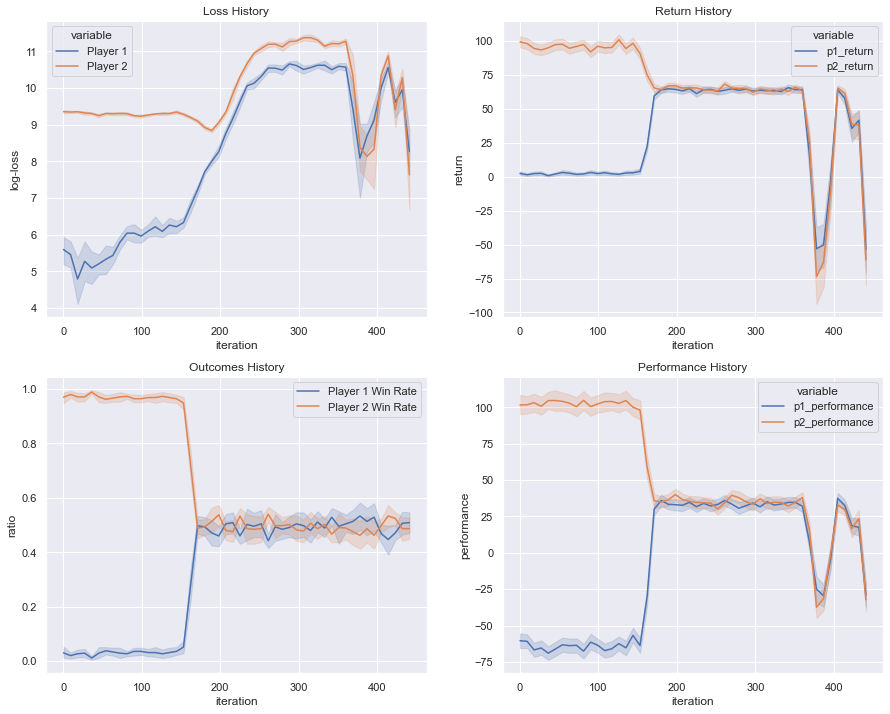

In [ ]:
try:
    if iteration > 1:
        plot_history()
        clear_output(wait=True)
    while iteration < num_iterations:
        collect_training_data()
        train()
        iteration += 1
        if iteration % test_interval == 0:
            plot_history(do_test=True)
            clear_output(wait=True)
        elif iteration % plot_interval == 0:
            plot_history()
            clear_output(wait=True)

except KeyboardInterrupt:
    clear_output(wait=True)
    print('Interrupting training, plotting history...')
    plot_history()



In [ ]:
for _ in range(10):
    last_timestep = test(auction, player_1, player_2)
    obs = last_timestep.observation.numpy()

    player_1_revenue = true_reward(last_timestep.observation, 1)
    player_2_revenue = true_reward(last_timestep.observation, 2)

    player_1_items = obs[0,0,1]
    player_2_items = obs[0,0,2]
    print(f"Price was: {obs[0,0,0]}")
    print(f"Player 1 won {player_1_items} with revenue {player_1_revenue}")
    print(f"Player 2 won {player_2_items} with revenue {player_2_revenue}")